In [1]:
import pandas as pd
import numpy as np
import datetime
import requests
import json
import os
import time
import ftplib
from pyproj import Transformer
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

In [2]:
heure_debut=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
dir_api = "./api/"
dir_apiinsee = "./api/"+datetime.now().strftime('%Y%m%d')
if not os.path.exists(dir_apiinsee):
    os.makedirs(dir_apiinsee)
api_file = open("./data/apikey.txt", "r")
apikey = api_file.read()
api_file.close()
#api_file = open("./data/inseekey.txt", "r")
api_file = open("./data/inseekey2.txt", "r")
inseekey = api_file.read()
api_file.close()
api_file = open("./data/apikeyods.txt", "r")
apikeyods = api_file.read()
api_file.close()
ftp_file = open("./data/ftp_HOSTNAME.txt", "r")
ftp_HOSTNAME = ftp_file.read()
ftp_file.close()
ftp_file = open("./data/ftp_USERNAME.txt", "r")
ftp_USERNAME = ftp_file.read()
ftp_file.close()
ftp_file = open("./data/ftp_PASSWORD.txt", "r")
ftp_PASSWORD = ftp_file.read()
ftp_file.close()
categoriesJuridiques = pd.read_excel('./data/categorieJuridiqueUniteLegale.xlsx',dtype=str)
categoriesJuridiques=categoriesJuridiques[['categorieJuridiqueUniteLegale','categorieJuridiqueUniteLegaleLib']]
activitePrincipaleUniteLegale = pd.read_excel('./data/activitePrincipaleUniteLegale.xlsx',dtype=str)
maj_structures_sirene_prec=pd.read_parquet("./data/maj_structures_sirene_prec.parquet", engine='pyarrow')

In [3]:
#url='https://docs.google.com/spreadsheet/ccc?key=1FwPq5Qw7Gbgj_sBD6Za4dfDDk6ydozQ99TyRjLkW5d8&output=xls'
#ref = pd.read_excel(url, sheet_name=['LES_COMMUNES'], dtype=str, na_filter=False)
#les_communes=ref.get("LES_COMMUNES")
#les_communes.columns= les_communes.columns.str.lower()
#les_communes.to_parquet("./data/les_communes.parquet")
les_communes=pd.read_parquet("./data/les_communes.parquet", engine='pyarrow')

In [4]:
#if os.path.isfile(dir_apiinsee+"/access_token.json"):
#    f = open(dir_apiinsee+"/access_token.json")
#    result = json.load(f)
#    f.close()
#else:
#    try:
#        headers = {
#            'Authorization': 'Basic '+inseekey,
#            'Content-Type': 'application/x-www-form-urlencoded',
#        }
#        data = {
#            'grant_type': 'client_credentials',
#        }
#        response = requests.post('https://api.insee.fr/token', headers=headers, data=data)
#        response.raise_for_status()
#        writeFile =open(dir_apiinsee+"/access_token.json", 'w')
#        json.dump(response.json(),writeFile)
#        writeFile.close()
#        result = response.json()
#        time.sleep(.6)
#    except requests.exceptions.HTTPError as errh:
#        print(access_token+" > KO : ", response.status_code)
#access_token = result["access_token"]
#access_token

In [5]:
headers = {
    'Accept': 'application/json',
    'X-API-KEY': apikey,
}
try:
    response = requests.get("https://api.paysage.dataesr.ovh/identifiers?filters[type]=siret&limit=10000", headers=headers)
    response.raise_for_status()
    result = response.json()
    sirets = pd.DataFrame(result["data"])
    time.sleep(.6)
except requests.exceptions.HTTPError as errh:
    print("siret > KO : ", response.status_code)
sirets=sirets.rename(columns={"value": "siret"})
sirets["dernier_traitement"]=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
sirets["url_paysage"]="https://paysage.enseignementsup-recherche.gouv.fr/structures/"+sirets["resourceId"]+"/presentation"
sirets["url_annuaire"]="https://annuaire-entreprises.data.gouv.fr/etablissement/"+sirets["siret"]
sirets["url_ods"]="https://data.enseignementsup-recherche.gouv.fr/explore/dataset/fr-esr-maj_structures_sirene/table/?sort=datedebut&refine.numero_siren="+sirets["siret"].str[:9]
les_sirets=sirets[(~sirets["siret"].isnull())]["siret"].drop_duplicates()
siret_paysage = sirets.copy()
siret_paysage["Siret_dans_paysage"] = "Oui"
siret_paysage=siret_paysage[(~siret_paysage["siret"].isnull())][["siret","Siret_dans_paysage"]].drop_duplicates()
siret_paysage=siret_paysage.rename(columns={"siret": "dern_numero_siret"})
les_sirens=les_sirets.str[:9].drop_duplicates()
les_sirens
siret_paysage2 = sirets.copy()
siret_paysage2["siren"]=siret_paysage2["siret"].str[:9]
siret_paysage2=siret_paysage2[["resourceId","siren"]].drop_duplicates()
siret_paysage2

,resourceId,siren
0,xYJ6W,879223923
1,9dqzd,393206743
2,v0kkd,835372483
3,k5EqK,775684897
4,ou06k,892414566
...,...,...
6299,xJdyB,130015332
6300,1tI7C,191333400
6301,8tVLr,191010602
6302,7CYWd,190609313


In [6]:
siren_paysage = (siret_paysage2.pivot_table(index=['siren'], values='resourceId', aggfunc=';'.join)
            .rename_axis(columns=None)
         ).reset_index()
siren_paysage['nb'] = siren_paysage["resourceId"].str.count(';')+1
siren_paysage_unique=siren_paysage[(siren_paysage['nb']==1)]

In [7]:
headers = {
    'Accept': 'application/json',
    'X-API-KEY': apikey,
}
try:
    response = requests.get("https://api.paysage.dataesr.ovh/identifiers?filters[type]=rna&limit=10000", headers=headers)
    response.raise_for_status()
    result = response.json()
    rnas = pd.DataFrame(result["data"])
    time.sleep(.6)
except requests.exceptions.HTTPError as errh:
    print("siret > KO : ", response.status_code)
rnas=rnas.rename(columns={"value": "identifiantAssociationUniteLegale"})
rnas["Rna_dans_paysage"] = "Oui"
Rna_paysage=rnas[(~rnas["identifiantAssociationUniteLegale"].isnull())][["identifiantAssociationUniteLegale","Rna_dans_paysage"]].drop_duplicates()
Rna_paysage

,identifiantAssociationUniteLegale,Rna_dans_paysage
0,W751276301,Oui
1,W133036847,Oui
2,W353021707,Oui
3,W313004321,Oui
4,W751265632,Oui
...,...,...
196,W601001426,Oui
197,W595008501,Oui
198,W595026827,Oui
199,W543003821,Oui


In [8]:
headers = {
    'X-INSEE-Api-Key-Integration': inseekey,
}
def extract_maj_sirene(dateheure,curseur="*"):
    global i
    i=i+1
    les_sirets_modifs = pd.DataFrame(columns = ["siret","dateDernierTraitementEtablissement"])
    cursor = curseur.replace("*","-")
    dateheure2 = datetime.now()
    dateheure2 = dateheure2.isoformat()
    dateheure2 = dateheure2[:13]
    params = {
        'q': 'dateDernierTraitementEtablissement:['+dateheure+' TO '+dateheure2+']',
        'champs': 'siret,dateDernierTraitementEtablissement',
        'nombre': '1000',
        'curseur': curseur
    }
    if os.path.isfile(dir_apiinsee+"/modifs_-_"+cursor+".json"):
        f = open(dir_apiinsee+"/modifs_-_"+cursor+".json")
        result = json.load(f)
        f.close()
    else:
        response = requests.get('https://api.insee.fr/api-sirene/3.11/siret', params=params, headers=headers)
        writeFile =open(dir_apiinsee+"/modifs_-_"+cursor+".json", 'w')
        json.dump(response.json(),writeFile)
        writeFile.close()
        result = response.json()
        time.sleep(2.1)
    if result["header"]["statut"]==200:
        les_sirets_modif = pd.DataFrame(result["etablissements"])
        les_sirets_modifs = pd.concat([les_sirets_modifs, les_sirets_modif], axis=0, join='outer')
        curseurSuivant=result["header"]["curseurSuivant"]
        if curseurSuivant != curseur :
            if i==1 :
                print("Total : "+str(result["header"]["total"]))
            if i%25==0 :
                print(str(i)+"000 - "+datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            les_sirets_modif = extract_maj_sirene(dateheure,curseurSuivant)
            les_sirets_modif = pd.DataFrame(les_sirets_modif)
            les_sirets_modifs = pd.concat([les_sirets_modifs, les_sirets_modif], axis=0, join='outer')
        return les_sirets_modifs    

In [9]:
#debut = datetime.now() - relativedelta(days=6)
#fin = datetime.now() + relativedelta(hours=1)
#delta = timedelta(hours=1)
#dates = []
#while debut <= fin:
#    dates.append(debut.isoformat())
#    debut += delta
#i=0
#for date in dates:
les_sirets_modifs = pd.DataFrame(columns = ["siret","dateDernierTraitementEtablissement"])

In [10]:
i=0
les_sirets_modifs = pd.DataFrame(columns = ["siret","dateDernierTraitementEtablissement"])
dateheure = datetime.now() - relativedelta(days=10)
dateheure = dateheure.isoformat()
dateheure = dateheure[:13]
les_sirets_modif = extract_maj_sirene(dateheure)
les_sirets_modif = pd.DataFrame(les_sirets_modif)
les_sirets_modifs = pd.concat([les_sirets_modifs, les_sirets_modif], axis=0, join='outer')
les_sirets_modifs=les_sirets_modifs.drop_duplicates()
print("Terminé")

Total : 126825
25000 - 2024-12-03 11:18:41
50000 - 2024-12-03 11:19:39
75000 - 2024-12-03 11:20:39
100000 - 2024-12-03 11:21:38
125000 - 2024-12-03 11:22:38
Terminé


In [11]:
print(les_sirets_modifs)

              siret dateDernierTraitementEtablissement
0    00665008900037            2024-11-27T08:25:45.849
1    00695012500010            2024-11-26T05:16:09.079
2    00802084400018            2024-11-27T08:38:30.632
3    00802238600018            2024-11-27T08:38:30.982
4    00802267500014            2024-11-27T08:38:30.358
..              ...                                ...
820  99843760200043            2024-11-26T13:10:34.801
821  99889300200142            2024-11-26T17:05:49.739
822  99889300200217            2024-11-29T17:02:46.993
823  99999030200047            2024-11-26T05:31:34.206
824  99999036900095            2024-12-02T10:31:49.640

[126825 rows x 2 columns]


In [12]:
les_siretss=pd.DataFrame(les_sirets)
les_siretss=les_siretss.rename(columns={0: "siret"})
les_sirets_a_gerer=pd.merge(les_siretss,les_sirets_modifs,how='inner',on=['siret'])
les_sirets_a_gerer

,siret,dateDernierTraitementEtablissement
0,87922392300035,2024-11-29T12:01:02.192
1,89241456600042,2024-11-28T09:26:25.153
2,89226480500037,2024-11-28T13:16:15.933
3,90922180600021,2024-11-28T07:48:42.365
4,85103486800022,2024-11-27T08:25:05.925
...,...,...
60,55208131766522,2024-11-30T05:15:42.681
61,50762055700045,2024-11-26T13:10:03.170
62,18004619500012,2024-11-28T05:25:53.003
63,19624401600016,2024-11-30T05:23:15.127


In [13]:
nbfic = 0
for ind in les_sirets_a_gerer.index:
    numero_siret = les_sirets_a_gerer['siret'][ind]
    numero_siren= numero_siret[:9]
    fname = dir_api+"/"+numero_siret+".json"
    if os.path.isfile(fname):
        os.remove(fname)
        nbfic+=1
    fname = dir_api+"/"+numero_siren+".json"
    if os.path.isfile(fname):
        os.remove(fname)
        nbfic+=1
if nbfic>1:
    print(str(nbfic)+" fichier(s) json supprimé(s)")
else:
    print(str(nbfic)+" fichier json supprimé")

123 fichier(s) json supprimé(s)


In [14]:
headers = {
    'X-INSEE-Api-Key-Integration': inseekey,
}
def extract_siren(numero_siren):
    structure = {}
    structure["numero_siren"] = numero_siren
    sep=";"
    params = {
        'q': 'siren:'+numero_siren,
        'masquerValeursNulles' : 'true'
    }
    if os.path.isfile(dir_api+"/"+numero_siren+".json"):
        f = open(dir_api+"/"+numero_siren+".json")
        result = json.load(f)
        f.close()
    else:
        response = requests.get('https://api.insee.fr/api-sirene/3.11/siren', params=params, headers=headers)
        writeFile =open(dir_api+"/"+numero_siren+".json", 'w')
        json.dump(response.json(),writeFile)
        writeFile.close()
        result = response.json()
        time.sleep(2.02)
    structure["statut"] = result["header"]["statut"]
    if result["header"]["statut"]==200:
        if "unitesLegales" in result:
            if "dateCreationUniteLegale" in result["unitesLegales"][0]:
                structure["dateCreationUniteLegale"]=result["unitesLegales"][0]["dateCreationUniteLegale"]
            if "identifiantAssociationUniteLegale" in result["unitesLegales"][0]:
                structure["identifiantAssociationUniteLegale"]=result["unitesLegales"][0]["identifiantAssociationUniteLegale"]
            if "sigleUniteLegale" in result["unitesLegales"][0]:
                structure["sigleUniteLegale"]=result["unitesLegales"][0]["sigleUniteLegale"]
            if "dateDernierTraitementUniteLegale" in result["unitesLegales"][0]:
                structure["dateDernierTraitementUniteLegale"]=result["unitesLegales"][0]["dateDernierTraitementUniteLegale"]
            if "categorieEntreprise" in result["unitesLegales"][0]:
                structure["categorieEntreprise"]=result["unitesLegales"][0]["categorieEntreprise"]
            if result["unitesLegales"][0]["nombrePeriodesUniteLegale"]>0:
                if "dateDebut" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["dateDebutDerniere"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["dateDebut"]
                if "dateFin" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["dateFinDerniere"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["dateFin"]
                if "denominationUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["denominationUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["denominationUniteLegale"]
                if "nomUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["nomUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["nomUniteLegale"]
                if "nomUsageUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["nomUsageUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["nomUsageUniteLegale"]
                if "denominationUsuelle1UniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["denominationUsuelle1UniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["denominationUsuelle1UniteLegale"]
                if "denominationUsuelle2UniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["denominationUsuelle2UniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["denominationUsuelle2UniteLegale"]
                if "denominationUsuelle3UniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["denominationUsuelle3UniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["denominationUsuelle3UniteLegale"]
                if "etatAdministratifUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["etatAdministratifUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["etatAdministratifUniteLegale"]
                if "nicSiegeUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["nicSiegeUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["nicSiegeUniteLegale"]
                    structure["numero_siret"]=numero_siren+result["unitesLegales"][0]["periodesUniteLegale"][0]["nicSiegeUniteLegale"]
                if "categorieJuridiqueUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["categorieJuridiqueUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["categorieJuridiqueUniteLegale"]
                if "activitePrincipaleUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["activitePrincipaleUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["activitePrincipaleUniteLegale"]
                if "nomenclatureActivitePrincipaleUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["nomenclatureActivitePrincipaleUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["nomenclatureActivitePrincipaleUniteLegale"]
                if "changementEtatAdministratifUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["changementEtatAdministratifUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["changementEtatAdministratifUniteLegale"]
                if "changementNomUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["changementNomUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["changementNomUniteLegale"]
                if "changementNomUsageUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["changementNomUsageUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["changementNomUsageUniteLegale"]
                if "changementDenominationUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["changementDenominationUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["changementDenominationUniteLegale"]
                if "changementDenominationUsuelleUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["changementDenominationUsuelleUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["changementDenominationUsuelleUniteLegale"]
                if "changementCategorieJuridiqueUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["changementCategorieJuridiqueUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["changementCategorieJuridiqueUniteLegale"]
                identifiers = pd.DataFrame(result["unitesLegales"][0]["periodesUniteLegale"])
                if identifiers["categorieJuridiqueUniteLegale"].count() > 0:
                    categoriesJuridiques=identifiers["categorieJuridiqueUniteLegale"].dropna().unique()
                    structure["categoriesJuridiques"] = sep.join(map(str, categoriesJuridiques))
                    structure["categoriesJuridiquesCompte"] = len(categoriesJuridiques)
    return structure

In [15]:
structures=pd.DataFrame(columns = ["numero_siren","dateCreationUniteLegale"])
i=0
for ind in les_sirens.index:
    numero_siren = les_sirens[ind]
    i=i+1
    if i%250==0:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')+" "+str(i)+"/{:0.1f} %".format(i*100/len(les_sirens.index)))
    structure = extract_siren(numero_siren)
    structure = pd.DataFrame(structure, index=[0])
    if (structures.empty) & (not structure.empty):
        structures = structure
    elif not structure.empty:
        structures = pd.concat([structures, structure], axis=0, join='outer')
print("Terminé")

2024-12-03 11:23:12 250/4.8 %
2024-12-03 11:23:22 500/9.6 %
2024-12-03 11:23:32 750/14.4 %
2024-12-03 11:23:35 1000/19.2 %
2024-12-03 11:23:39 1250/24.0 %
2024-12-03 11:23:40 1500/28.8 %
2024-12-03 11:23:44 1750/33.6 %
2024-12-03 11:23:48 2000/38.4 %
2024-12-03 11:24:00 2250/43.3 %
2024-12-03 11:24:08 2500/48.1 %
2024-12-03 11:24:18 2750/52.9 %
2024-12-03 11:24:22 3000/57.7 %
2024-12-03 11:24:36 3250/62.5 %
2024-12-03 11:24:42 3500/67.3 %
2024-12-03 11:24:46 3750/72.1 %
2024-12-03 11:24:49 4000/76.9 %
2024-12-03 11:24:57 4250/81.7 %
2024-12-03 11:25:03 4500/86.5 %
2024-12-03 11:25:16 4750/91.3 %
2024-12-03 11:25:19 5000/96.1 %
Terminé


In [16]:
structures

,numero_siren,statut,dateCreationUniteLegale,dateDernierTraitementUniteLegale,categorieEntreprise,dateDebutDerniere,denominationUniteLegale,etatAdministratifUniteLegale,nicSiegeUniteLegale,numero_siret,...,changementDenominationUsuelleUniteLegale,changementCategorieJuridiqueUniteLegale,categoriesJuridiques,categoriesJuridiquesCompte,identifiantAssociationUniteLegale,denominationUsuelle1UniteLegale,sigleUniteLegale,denominationUsuelle2UniteLegale,nomUniteLegale,nomUsageUniteLegale
0,879223923,200,2019-09-15,2024-11-29T12:01:02.196,PME,2024-10-24,SPORTSDYNAMICS,A,00035,87922392300035,...,False,False,5710,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0,393206743,200,1993-11-25,2024-08-29T05:25:58.033,ETI,2024-06-19,BRGM INVEST,A,00022,39320674300022,...,False,False,5599,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0,835372483,200,2018-02-12,2024-03-22T14:26:06.001,PME,2019-12-16,TERRA INNOVA,A,00023,83537248300023,...,False,False,5710,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0,775684897,200,1887-06-04,2024-03-22T14:26:06.000,ETI,2016-01-01,INSTITUT PASTEUR,A,00017,77568489700017,...,False,False,9300,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0,892414566,200,2020-12-23,2024-11-28T09:26:25.171,PME,2024-09-26,MECAWARE,A,00042,89241456600042,...,False,False,5710,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,191700327,200,1993-01-28,2024-03-22T14:26:06.000,ETI,2018-10-15,LA ROCHELLE UNIVERSITE,A,00015,19170032700015,...,False,False,7383,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0,130021330,200,2014-12-29,2024-03-22T14:26:06.000,PME,2014-12-29,COMMUNAUTE UNIVERSITES ET ETABLISSEMENTS NORMA...,A,00019,13002133000019,...,False,False,7383,1.0,NaN,NaN,COMUE,NaN,NaN,NaN
0,191333400,200,2003-10-01,2024-03-22T14:26:06.000,PME,2008-01-01,ECOLE CENTRALE DE MARSEILLE,A,00015,19133340000015,...,False,False,7383,1.0,NaN,NaN,CENTRALE MARSEILLE,NaN,NaN,NaN
0,190609313,200,1970-06-10,2024-03-22T14:26:06.000,NaN,2020-01-01,UNIVERSITE DE NICE,C,00019,19060931300019,...,False,False,7383,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
epsg = {'D001':'EPSG:2154','D002':'EPSG:2154','D003':'EPSG:2154','D004':'EPSG:2154','D005':'EPSG:2154','D006':'EPSG:2154','D007':'EPSG:2154','D008':'EPSG:2154','D009':'EPSG:2154','D010':'EPSG:2154','D011':'EPSG:2154','D012':'EPSG:2154','D013':'EPSG:2154','D014':'EPSG:2154','D015':'EPSG:2154','D016':'EPSG:2154','D017':'EPSG:2154','D018':'EPSG:2154','D019':'EPSG:2154','D021':'EPSG:2154','D022':'EPSG:2154','D023':'EPSG:2154','D024':'EPSG:2154','D025':'EPSG:2154','D026':'EPSG:2154','D027':'EPSG:2154','D028':'EPSG:2154','D029':'EPSG:2154','D02A':'EPSG:2154','D02B':'EPSG:2154','D030':'EPSG:2154','D031':'EPSG:2154','D032':'EPSG:2154','D033':'EPSG:2154','D034':'EPSG:2154','D035':'EPSG:2154','D036':'EPSG:2154','D037':'EPSG:2154','D038':'EPSG:2154','D039':'EPSG:2154','D040':'EPSG:2154','D041':'EPSG:2154','D042':'EPSG:2154','D043':'EPSG:2154','D044':'EPSG:2154','D045':'EPSG:2154','D046':'EPSG:2154','D047':'EPSG:2154','D048':'EPSG:2154','D049':'EPSG:2154','D050':'EPSG:2154','D051':'EPSG:2154','D052':'EPSG:2154','D053':'EPSG:2154','D054':'EPSG:2154','D055':'EPSG:2154','D056':'EPSG:2154','D057':'EPSG:2154','D058':'EPSG:2154','D059':'EPSG:2154','D060':'EPSG:2154','D061':'EPSG:2154','D062':'EPSG:2154','D063':'EPSG:2154','D064':'EPSG:2154','D065':'EPSG:2154','D066':'EPSG:2154','D067':'EPSG:2154','D068':'EPSG:2154','D069':'EPSG:2154','D070':'EPSG:2154','D071':'EPSG:2154','D072':'EPSG:2154','D073':'EPSG:2154','D074':'EPSG:2154','D075':'EPSG:2154','D076':'EPSG:2154','D077':'EPSG:2154','D078':'EPSG:2154','D079':'EPSG:2154','D080':'EPSG:2154','D081':'EPSG:2154','D082':'EPSG:2154','D083':'EPSG:2154','D084':'EPSG:2154','D085':'EPSG:2154','D086':'EPSG:2154','D087':'EPSG:2154','D088':'EPSG:2154','D089':'EPSG:2154','D090':'EPSG:2154','D091':'EPSG:2154','D092':'EPSG:2154','D093':'EPSG:2154','D094':'EPSG:2154','D095':'EPSG:2154','D971':'EPSG:5490','D972':'EPSG:5490','D973':'EPSG:2972','D974':'EPSG:2975','D975':'EPSG:4467','D976':'EPSG:4471','D978':'EPSG:5490','D986':'EPSG:8903','D987':'EPSG:6687','D988':'EPSG:3163'}
les_communes2=les_communes[(les_communes["reg_id"]!="R99")&(les_communes["reg_id"]!="R00")][["com_code","dep_id"]].rename(columns={"com_code": "codeCommuneEtablissement","dep_id": "epsg"}).drop_duplicates(subset=['codeCommuneEtablissement'])
les_communes2=les_communes2.replace({"epsg": epsg})

In [18]:
les_sirets= pd.concat([les_sirets, structures["numero_siret"].drop_duplicates()], axis=0, join='outer').drop_duplicates().reset_index()
les_sirets=les_sirets[(~les_sirets[0].isnull())][[0]].drop_duplicates()
les_sirets

,0
0,87922392300035
1,39320674300022
2,83537248300023
3,77568489700066
4,89241456600042
...,...
6427,78461701100027
6428,78475641300117
6429,75080177100023
6430,18640005700011


In [19]:
headers = {
    'X-INSEE-Api-Key-Integration': inseekey,
}
def extract_data_siret(numero_siret):
    structure = {}
    numero_siren = numero_siret[:9]
    structure["siren"] = numero_siren
    structure["siret"] = numero_siret
    sep=";"
    params = {
        'q': 'siret:'+numero_siret,
        'masquerValeursNulles' : 'true'
    }
    if os.path.isfile(dir_api+"/"+numero_siret+".json"):
        f = open(dir_api+"/"+numero_siret+".json")
        result = json.load(f)
        f.close()
    else:
        response = requests.get('https://api.insee.fr/api-sirene/3.11/siret', params=params, headers=headers)
        #response.raise_for_status()
        writeFile =open(dir_api+"/"+numero_siret+".json", 'w')
        json.dump(response.json(),writeFile)
        writeFile.close()
        result = response.json()
        time.sleep(2.02)
    structure["statut"] = result["header"]["statut"]
    structure["message"] = result["header"]["message"]
    if result["header"]["statut"]==200:
        if "etablissements" in result:
            if "etablissementSiege" in result["etablissements"][0]:
                structure["etablissementSiege"]=result["etablissements"][0]["etablissementSiege"]            
            if "dateCreationEtablissement" in result["etablissements"][0]:
                structure["dateCreationEtablissement"]=result["etablissements"][0]["dateCreationEtablissement"]            
            if "dateDernierTraitementEtablissement" in result["etablissements"][0]:
                structure["dateDernierTraitementEtablissement"]=result["etablissements"][0]["dateDernierTraitementEtablissement"]            
            if "uniteLegale" in result["etablissements"][0]:
                if "etatAdministratifUniteLegale" in result["etablissements"][0]["uniteLegale"]:
                    structure["etatAdministratifUniteLegale"]=result["etablissements"][0]["uniteLegale"]["etatAdministratifUniteLegale"]            
                if "dateCreationUniteLegale" in result["etablissements"][0]["uniteLegale"]:
                    structure["dateCreationUniteLegale"]=result["etablissements"][0]["uniteLegale"]["dateCreationUniteLegale"]            
                if "nicSiegeUniteLegale" in result["etablissements"][0]["uniteLegale"]:
                    structure["siretSiege"]=numero_siren+result["etablissements"][0]["uniteLegale"]["nicSiegeUniteLegale"]
                if "sigleUniteLegale" in result["etablissements"][0]["uniteLegale"]:
                    structure["sigleUniteLegale"]=result["etablissements"][0]["uniteLegale"]["sigleUniteLegale"]            
                if "denominationUniteLegale" in result["etablissements"][0]["uniteLegale"]:
                    structure["denominationUniteLegale"]=result["etablissements"][0]["uniteLegale"]["denominationUniteLegale"]            
                if "categorieJuridiqueUniteLegale" in result["etablissements"][0]["uniteLegale"]:
                    structure["categorieJuridiqueUniteLegale"]=result["etablissements"][0]["uniteLegale"]["categorieJuridiqueUniteLegale"]            
            if "adresseEtablissement" in result["etablissements"][0]:
                if "numeroVoieEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["numeroVoieEtablissement"]=str(result["etablissements"][0]["adresseEtablissement"]["numeroVoieEtablissement"])
                if "dernierNumeroVoieEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["dernierNumeroVoieEtablissement"]=str(result["etablissements"][0]["adresseEtablissement"]["dernierNumeroVoieEtablissement"])
                if "typeVoieEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["typeVoieEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["typeVoieEtablissement"]            
                if "libelleVoieEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["libelleVoieEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["libelleVoieEtablissement"]            
                if "complementAdresseEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["complementAdresseEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["complementAdresseEtablissement"]            
                if "codePostalEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["codePostalEtablissement"]=str(result["etablissements"][0]["adresseEtablissement"]["codePostalEtablissement"])
                if "libelleCommuneEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["libelleCommuneEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["libelleCommuneEtablissement"]            
                if "codePaysEtrangerEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["codePaysEtrangerEtablissement"]=str(result["etablissements"][0]["adresseEtablissement"]["codePaysEtrangerEtablissement"])
                if "libellePaysEtrangerEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["libellePaysEtrangerEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["libellePaysEtrangerEtablissement"]            
                if "libelleCommuneEtrangerEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["libelleCommuneEtrangerEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["libelleCommuneEtrangerEtablissement"]            
                if "coordonneeLambertAbscisseEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["coordonneeEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["coordonneeLambertAbscisseEtablissement"]+","+result["etablissements"][0]["adresseEtablissement"]["coordonneeLambertOrdonneeEtablissement"]
                if "identifiantAdresseEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["identifiantAdresseEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["identifiantAdresseEtablissement"]            
                if "codeCommuneEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["codeCommuneEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["codeCommuneEtablissement"]            
            if "periodesEtablissement" in result["etablissements"][0]:
                if "dateDebut" in result["etablissements"][0]["periodesEtablissement"]:
                    structure["dateDebut"]=result["etablissements"][0]["periodesEtablissement"][0]["dateDebut"]
                if "etatAdministratifEtablissement" in result["etablissements"][0]["periodesEtablissement"]:
                    structure["etatAdministratifEtablissement"]=result["etablissements"][0]["periodesEtablissement"][0]["etatAdministratifEtablissement"]            
                if "changementDenominationUsuelleEtablissement" in result["etablissements"][0]["periodesEtablissement"]:
                    structure["changementDenominationUsuelleEtablissement"]=result["etablissements"][0]["changementDenominationUsuelleEtablissement"][0]["etatAdministratifUniteLegale"]            
                if "changementEnseigneEtablissement" in result["etablissements"][0]["periodesEtablissement"]:
                    structure["changementEnseigneEtablissement"]=result["etablissements"][0]["periodesEtablissement"][0]["changementEnseigneEtablissement"]            
                if "changementEtatAdministratifEtablissement" in result["etablissements"][0]["periodesEtablissement"]:
                    structure["changementEtatAdministratifEtablissement"]=result["etablissements"][0]["periodesEtablissement"][0]["changementEtatAdministratifEtablissement"]            
    return structure

In [20]:
numero_siret

'13001727000146'

In [21]:
structures=pd.DataFrame(columns = ["siren","siretSiege","siret"])
i=0
for ind in les_sirets.index:
    numero_siret = les_sirets[0][ind]
    if i%250==0:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')+" "+str(i)+"/{:0.1f} %".format(i*100/len(les_sirets.index)))
    i=i+1
    structure = extract_data_siret(numero_siret)
    structure = pd.DataFrame(structure, index=[0])
    if (structures.empty) & (not structure.empty):
        structures = structure
    elif not structure.empty:
        structures = pd.concat([structures, structure], axis=0, join='outer')
print("Terminé")

2024-12-03 11:25:21 0/0.0 %
2024-12-03 11:25:48 250/3.9 %
2024-12-03 11:25:57 500/7.8 %
2024-12-03 11:26:07 750/11.7 %
2024-12-03 11:26:12 1000/15.5 %
2024-12-03 11:26:13 1250/19.4 %
2024-12-03 11:26:15 1500/23.3 %
2024-12-03 11:26:16 1750/27.2 %
2024-12-03 11:26:21 2000/31.1 %
2024-12-03 11:26:39 2250/35.0 %
2024-12-03 11:26:41 2500/38.9 %
2024-12-03 11:26:59 2750/42.8 %
2024-12-03 11:27:01 3000/46.6 %
2024-12-03 11:27:09 3250/50.5 %
2024-12-03 11:27:21 3500/54.4 %
2024-12-03 11:27:23 3750/58.3 %
2024-12-03 11:27:31 4000/62.2 %
2024-12-03 11:27:35 4250/66.1 %
2024-12-03 11:27:36 4500/70.0 %
2024-12-03 11:27:45 4750/73.9 %
2024-12-03 11:27:51 5000/77.7 %
2024-12-03 11:27:52 5250/81.6 %
2024-12-03 11:28:03 5500/85.5 %
2024-12-03 11:28:06 5750/89.4 %
2024-12-03 11:28:12 6000/93.3 %
2024-12-03 11:28:16 6250/97.2 %
Terminé


In [22]:
dateDernierTraitementEtablissement=structures[['siren','dateDernierTraitementEtablissement']].drop_duplicates("siren")
dateDernierTraitementEtablissement=dateDernierTraitementEtablissement.rename(columns={"siren": "numero_siren"})
structures

,siren,siret,statut,message,etablissementSiege,dateCreationEtablissement,dateDernierTraitementEtablissement,etatAdministratifUniteLegale,dateCreationUniteLegale,siretSiege,...,libelleCommuneEtablissement,coordonneeEtablissement,identifiantAdresseEtablissement,codeCommuneEtablissement,complementAdresseEtablissement,sigleUniteLegale,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,libelleCommuneEtrangerEtablissement,dernierNumeroVoieEtablissement
0,879223923,87922392300035,200,OK,True,2024-10-24,2024-11-29T12:01:02.192,A,2019-09-15,87922392300035,...,SAINT-MANDE,"657247.81,6860728.93",940674137_B,94067,NaN,NaN,NaN,NaN,NaN,NaN
0,393206743,39320674300022,200,OK,True,1994-01-03,2024-08-29T05:25:58.038,A,1993-11-25,39320674300022,...,ORLEANS,"620491.5656950034,6748259.060153749",452341682_B,45234,NaN,NaN,NaN,NaN,NaN,NaN
0,835372483,83537248300023,200,OK,True,2019-12-16,2024-03-30T15:24:34.314,A,2018-02-12,83537248300023,...,VERTOU,"359394.7963074289,6685267.379846245",442151201_B,44215,NaN,NaN,NaN,NaN,NaN,NaN
0,775684897,77568489700066,200,OK,False,1948-01-01,2024-03-30T06:45:57.670,A,1887-06-04,77568489700017,...,LES ABYMES,"657242.9067447983,1795384.363719451",97101B165_B,97101,NaN,NaN,NaN,NaN,NaN,NaN
0,892414566,89241456600042,200,OK,True,2023-09-01,2024-11-28T09:26:25.153,A,2020-12-23,89241456600042,...,VENISSIEUX,"846344.0269896549,6514612.3649389725",692591090_B,69259,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,784617011,78461701100027,200,OK,True,1989-08-01,2024-03-30T11:35:14.174,A,1900-01-01,78461701100027,...,PARIS,"648128.4925053681,6863452.043919901",751165336_B,75116,006-014,CHEC,NaN,NaN,NaN,NaN
0,784756413,78475641300117,200,OK,True,1992-09-01,2024-03-30T12:24:38.894,A,1900-01-01,78475641300117,...,VILLEPINTE,"663788.9003225574,6874780.164699845",930781367_B,93078,ZI PARIS NORD II,IS,NaN,NaN,NaN,NaN
0,750801771,75080177100023,200,OK,True,2022-07-01,2024-03-30T00:35:39.566,A,2012-03-07,75080177100023,...,BOUGUENAIS,"352314.6186480904,6683114.7737259",440201993_B,44020,NaN,NaN,NaN,NaN,NaN,NaN
0,186400057,18640005700011,200,OK,True,1983-09-27,2024-03-30T18:41:10.471,A,1948-06-14,18640005700011,...,BAYONNE,"337008.8151680981,6276964.080286231",641020065_B,64102,50-51,CCI,NaN,NaN,NaN,NaN


In [23]:
structures=pd.merge(structures,les_communes2,how='left',on='codeCommuneEtablissement')

In [24]:
coordonneeEtablissement=structures[(~structures["coordonneeEtablissement"].isnull())&(structures["coordonneeEtablissement"]!="[ND],[ND]")][["siret","epsg","coordonneeEtablissement"]]
coordonneeEtablissement[['X', 'Y']] = coordonneeEtablissement['coordonneeEtablissement'].str.split(',', n=1, expand=True)
coordonneeEtablissement

,siret,epsg,coordonneeEtablissement,X,Y
0,87922392300035,EPSG:2154,"657247.81,6860728.93",657247.81,6860728.93
1,39320674300022,EPSG:2154,"620491.5656950034,6748259.060153749",620491.5656950034,6748259.060153749
2,83537248300023,EPSG:2154,"359394.7963074289,6685267.379846245",359394.7963074289,6685267.379846245
3,77568489700066,EPSG:5490,"657242.9067447983,1795384.363719451",657242.9067447983,1795384.363719451
4,89241456600042,EPSG:2154,"846344.0269896549,6514612.3649389725",846344.0269896549,6514612.3649389725
...,...,...,...,...,...
6426,78461701100027,EPSG:2154,"648128.4925053681,6863452.043919901",648128.4925053681,6863452.043919901
6427,78475641300117,EPSG:2154,"663788.9003225574,6874780.164699845",663788.9003225574,6874780.164699845
6428,75080177100023,EPSG:2154,"352314.6186480904,6683114.7737259",352314.6186480904,6683114.7737259
6429,18640005700011,EPSG:2154,"337008.8151680981,6276964.080286231",337008.8151680981,6276964.080286231


In [25]:
selection=(coordonneeEtablissement["X"].astype(float) < 1000) & (coordonneeEtablissement["Y"].astype(float) < 1000)
coordonneeEtablissement.loc[selection, 'epsg']="EPSG:4326"
coordonneeEtablissement

,siret,epsg,coordonneeEtablissement,X,Y
0,87922392300035,EPSG:2154,"657247.81,6860728.93",657247.81,6860728.93
1,39320674300022,EPSG:2154,"620491.5656950034,6748259.060153749",620491.5656950034,6748259.060153749
2,83537248300023,EPSG:2154,"359394.7963074289,6685267.379846245",359394.7963074289,6685267.379846245
3,77568489700066,EPSG:5490,"657242.9067447983,1795384.363719451",657242.9067447983,1795384.363719451
4,89241456600042,EPSG:2154,"846344.0269896549,6514612.3649389725",846344.0269896549,6514612.3649389725
...,...,...,...,...,...
6426,78461701100027,EPSG:2154,"648128.4925053681,6863452.043919901",648128.4925053681,6863452.043919901
6427,78475641300117,EPSG:2154,"663788.9003225574,6874780.164699845",663788.9003225574,6874780.164699845
6428,75080177100023,EPSG:2154,"352314.6186480904,6683114.7737259",352314.6186480904,6683114.7737259
6429,18640005700011,EPSG:2154,"337008.8151680981,6276964.080286231",337008.8151680981,6276964.080286231


In [26]:
coordonneeEtablissement["epsg"].drop_duplicates()

0      EPSG:2154
3      EPSG:5490
26     EPSG:2975
39     EPSG:4326
639    EPSG:2972
Name: epsg, dtype: object

In [27]:
def convertGPS(dftemp,epsg):
    df=dftemp.copy()
    xx, yy = Transformer.from_crs(epsg,"EPSG:4326",always_xy=True).transform(df["X"].values, df["Y"].values)
    df["XX"]=xx
    df["YY"]=yy
    if epsg=="EPSG:4326":
        df["coordonneeEtablissementGPS"]=df["XX"].astype(str)+","+df["YY"].astype(str)
    else :
        df["coordonneeEtablissementGPS"]=df["YY"].astype(str)+","+df["XX"].astype(str)
    return df.drop_duplicates("siret")
coordonneeEtablissementGPS=pd.DataFrame(columns = ["siret","epsg","coordonneeEtablissement","X","Y","XX","YY","coordonneeEtablissementGPS"])
for epsg in coordonneeEtablissement["epsg"].drop_duplicates():
    A=convertGPS(coordonneeEtablissement[(coordonneeEtablissement["epsg"]==epsg)],epsg)
    coordonneeEtablissementGPS = pd.concat([coordonneeEtablissementGPS, A], axis=0, join='outer')
coordonneeEtablissementGPS

,siret,epsg,coordonneeEtablissement,X,Y,XX,YY,coordonneeEtablissementGPS
0,87922392300035,EPSG:2154,"657247.81,6860728.93",657247.81,6860728.93,2.417459,48.845187,"48.84518701681063,2.4174589727800364"
1,39320674300022,EPSG:2154,"620491.5656950034,6748259.060153749",620491.5656950034,6748259.060153749,1.937290,47.829911,"47.82991100000001,1.9372899999999997"
2,83537248300023,EPSG:2154,"359394.7963074289,6685267.379846245",359394.7963074289,6685267.379846245,-1.499892,47.180321,"47.180321,-1.499891999999999"
4,89241456600042,EPSG:2154,"846344.0269896549,6514612.3649389725",846344.0269896549,6514612.3649389725,4.881371,45.715400,"45.7154,4.881370999999998"
5,89226480500037,EPSG:2154,"913345.6,6455606.01",913345.6,6455606.01,5.716070,45.166730,"45.16672998901862,5.716070024730379"
...,...,...,...,...,...,...,...,...
6276,19101060200032,EPSG:4326,"48.272346,4.07644",48.272346,4.07644,48.272346,4.076440,"48.272346,4.07644"
6278,59702084100016,EPSG:4326,"47.332321,1.200063",47.332321,1.200063,47.332321,1.200063,"47.332321,1.200063"
6279,59702084101253,EPSG:4326,"48.731985,2.371071",48.731985,2.371071,48.731985,2.371071,"48.731985,2.371071"
639,51795713000043,EPSG:2972,"317513.21,571153.87",317513.21,571153.87,-52.646380,5.165132,"5.165132009933544,-52.64638003259168"


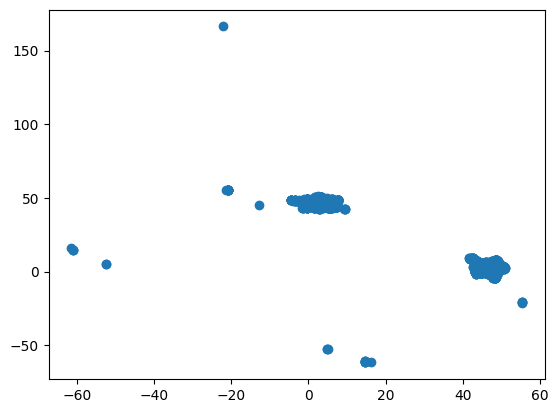

In [28]:
plt.scatter(x=coordonneeEtablissementGPS['XX'], y=coordonneeEtablissementGPS['YY'])
plt.show()

In [29]:
coordonneeEtablissementGPS=coordonneeEtablissementGPS[["siret","coordonneeEtablissementGPS"]]
structures=pd.merge(structures,coordonneeEtablissementGPS,how='left',on='siret')

In [30]:
structures["Adresse"]=structures[['complementAdresseEtablissement','numeroVoieEtablissement','typeVoieEtablissement','libelleVoieEtablissement','codePostalEtablissement','libelleCommuneEtablissement']].agg(lambda x:' '.join(x.dropna().astype(str)), axis=1)
structures["Adresse"]

0        14 AVENUE DU GENERAL DE GAULLE 94160 SAINT-MANDE
1                 3 AVENUE CLAUDE GUILLEMIN 45100 ORLEANS
2                    1 RUE DES MONTGOLFIERES 44120 VERTOU
3                        MORNE JOLIVIERE 97139 LES ABYMES
4             41 BOULEVARD MARCEL SEMBAT 69200 VENISSIEUX
                              ...                        
6426                 006-014 6 RUE LA PEROUSE 75016 PARIS
6427    ZI PARIS NORD II 90 RUE DES VANESSES 93420 VIL...
6428            1 MAIL DES 20 000 LIEUES 44340 BOUGUENAIS
6429                50-51 50 ALLEES MARINES 64100 BAYONNE
6430               2 RUE D'ALSACE LORRAINE 31000 TOULOUSE
Name: Adresse, Length: 6431, dtype: object

In [31]:
structures

,siren,siret,statut,message,etablissementSiege,dateCreationEtablissement,dateDernierTraitementEtablissement,etatAdministratifUniteLegale,dateCreationUniteLegale,siretSiege,...,codeCommuneEtablissement,complementAdresseEtablissement,sigleUniteLegale,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,libelleCommuneEtrangerEtablissement,dernierNumeroVoieEtablissement,epsg,coordonneeEtablissementGPS,Adresse
0,879223923,87922392300035,200,OK,True,2024-10-24,2024-11-29T12:01:02.192,A,2019-09-15,87922392300035,...,94067,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"48.84518701681063,2.4174589727800364",14 AVENUE DU GENERAL DE GAULLE 94160 SAINT-MANDE
1,393206743,39320674300022,200,OK,True,1994-01-03,2024-08-29T05:25:58.038,A,1993-11-25,39320674300022,...,45234,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"47.82991100000001,1.9372899999999997",3 AVENUE CLAUDE GUILLEMIN 45100 ORLEANS
2,835372483,83537248300023,200,OK,True,2019-12-16,2024-03-30T15:24:34.314,A,2018-02-12,83537248300023,...,44215,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"47.180321,-1.499891999999999",1 RUE DES MONTGOLFIERES 44120 VERTOU
3,775684897,77568489700066,200,OK,False,1948-01-01,2024-03-30T06:45:57.670,A,1887-06-04,77568489700017,...,97101,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:5490,"16.234004,-61.52873699999999",MORNE JOLIVIERE 97139 LES ABYMES
4,892414566,89241456600042,200,OK,True,2023-09-01,2024-11-28T09:26:25.153,A,2020-12-23,89241456600042,...,69259,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"45.7154,4.881370999999998",41 BOULEVARD MARCEL SEMBAT 69200 VENISSIEUX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6426,784617011,78461701100027,200,OK,True,1989-08-01,2024-03-30T11:35:14.174,A,1900-01-01,78461701100027,...,75116,006-014,CHEC,NaN,NaN,NaN,NaN,EPSG:2154,"48.869006,2.2928729999999997",006-014 6 RUE LA PEROUSE 75016 PARIS
6427,784756413,78475641300117,200,OK,True,1992-09-01,2024-03-30T12:24:38.894,A,1900-01-01,78475641300117,...,93078,ZI PARIS NORD II,IS,NaN,NaN,NaN,NaN,EPSG:2154,"48.971945,2.5053859999999992",ZI PARIS NORD II 90 RUE DES VANESSES 93420 VIL...
6428,750801771,75080177100023,200,OK,True,2022-07-01,2024-03-30T00:35:39.566,A,2012-03-07,75080177100023,...,44020,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"47.157306,-1.5915709999999998",1 MAIL DES 20 000 LIEUES 44340 BOUGUENAIS
6429,186400057,18640005700011,200,OK,True,1983-09-27,2024-03-30T18:41:10.471,A,1948-06-14,18640005700011,...,64102,50-51,CCI,NaN,NaN,NaN,NaN,EPSG:2154,"43.49888100000001,-1.4886939999999984",50-51 50 ALLEES MARINES 64100 BAYONNE


In [32]:
writer = pd.ExcelWriter("./data/structures_"+datetime.now().strftime('%Y-%m-%d')+".xlsx", engine='xlsxwriter')
structures.to_excel(writer,sheet_name="data", index=False)
writer.close()

In [33]:
les__structures=pd.merge(sirets,structures,how='left',on=['siret'])
les__adresse=les__structures[["siret","Adresse","coordonneeEtablissementGPS"]].drop_duplicates('siret')
les__adresse=les__adresse.rename(columns={"siret": "dern_numero_siret"})
les__structures

,active,type,siret,resourceId,createdBy,createdAt,id,startDate,endDate,updatedBy,...,codeCommuneEtablissement,complementAdresseEtablissement,sigleUniteLegale,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,libelleCommuneEtrangerEtablissement,dernierNumeroVoieEtablissement,epsg,coordonneeEtablissementGPS,Adresse
0,True,siret,87922392300035,xYJ6W,"{'firstName': 'Yann', 'lastName': 'Caradec', '...",2024-12-02T10:42:17.009Z,j0rwt7x7o7zzjzz,2024-10-24,None,NaN,...,94067,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"48.84518701681063,2.4174589727800364",14 AVENUE DU GENERAL DE GAULLE 94160 SAINT-MANDE
1,NaN,siret,39320674300022,9dqzd,"{'firstName': 'Emmanuel', 'lastName': 'Weisenb...",2024-11-29T17:25:48.243Z,2kkur7zi1nh0xyq,None,None,NaN,...,45234,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"47.82991100000001,1.9372899999999997",3 AVENUE CLAUDE GUILLEMIN 45100 ORLEANS
2,True,siret,83537248300023,v0kkd,"{'firstName': 'Emmanuel', 'lastName': 'Weisenb...",2024-11-29T17:22:48.381Z,c7fxv2kx2xpumfp,2019-12-16,None,"{'firstName': 'Yann', 'lastName': 'Caradec', '...",...,44215,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"47.180321,-1.499891999999999",1 RUE DES MONTGOLFIERES 44120 VERTOU
3,True,siret,77568489700066,k5EqK,"{'firstName': 'zoe', 'lastName': 'Friant', 'id...",2024-11-29T14:17:03.864Z,qunvv4bs4pgdd8w,1948-01-01,None,NaN,...,97101,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:5490,"16.234004,-61.52873699999999",MORNE JOLIVIERE 97139 LES ABYMES
4,True,siret,89241456600042,ou06k,"{'firstName': 'Yann', 'lastName': 'Caradec', '...",2024-11-29T13:49:47.202Z,8k9qbufsb9322r9,2024-09-26,None,NaN,...,69259,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"45.7154,4.881370999999998",41 BOULEVARD MARCEL SEMBAT 69200 VENISSIEUX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6300,True,siret,19133340000015,1tI7C,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T18:51:27.578Z,1iS0Maw0viOj9am,None,None,NaN,...,13213,TECHNOPOLE CHATEAU GOMBERT,CENTRALE MARSEILLE,NaN,NaN,NaN,NaN,EPSG:2154,"43.341539,5.43639",TECHNOPOLE CHATEAU GOMBERT 38 RUE FREDERIC JOL...
6301,True,siret,19101060200032,8tVLr,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T18:51:26.539Z,RYLD0h34ZT4QFf7,None,None,NaN,...,10387,NaN,UTT,NaN,NaN,NaN,NaN,EPSG:2154,"48.272346,4.07644",12 RUE MARIE CURIE 10000 TROYES
6302,False,siret,19060931300019,7CYWd,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T18:51:26.155Z,yJld3FADbXaLsw9,None,None,NaN,...,06088,GRAND CHATEAU,NaN,NaN,NaN,NaN,NaN,EPSG:2154,NaN,GRAND CHATEAU 28 AV VALROSE 06000 NICE
6303,False,siret,59702084100016,18120,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T18:51:23.386Z,d2YbUlEQY0wIIxf,None,2021-11,NaN,...,41217,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"47.332321,1.200063",23 ROUTE DE TOURS 41400 SAINT-JULIEN-DE-CHEDON


In [34]:
filename_in = "./data/les_structures_"+datetime.now().strftime('%Y-%m-%d')+".xlsx"
writer = pd.ExcelWriter(filename_in, engine='xlsxwriter')
les__structures.to_excel(writer,sheet_name="data", index=False)
writer.close()
ftp_server = ftplib.FTP(ftp_HOSTNAME, ftp_USERNAME, ftp_PASSWORD)
filename_out = "les_structures.xlsx"
with open(filename_in, "rb") as file:
    ftp_server.storbinary(f"STOR {filename_out}", file)
print(ftp_server.dir())
ftp_server.quit()

drwx---r-x    2 25811      users              17 Dec  3 11:28 .
drwx---r-x    2 25811      users              17 Dec  3 11:28 ..
-rw----r--    1 25811      users          603138 Mar  5  2024 CII.xlsx
-rw----r--    1 25811      users         3435698 Mar  5  2024 CIR.xlsx
-rw----r--    1 25811      users           41003 Mar  5  2024 ORGANISMES.xlsx
-rw----r--    1 25811      users         1678436 Mar  5  2024 _CII.xlsx
-rw----r--    1 25811      users         8777350 Mar  5  2024 _CIR.xlsx
-rw----r--    1 25811      users           79559 Mar  5  2024 _ORGANISMES.xlsx
-rw----r--    1 25811      users          244292 Nov 22 10:13 biblio.xlsx
-rw----r--    1 25811      users           21901 Nov 22 10:14 cc.xlsx
-rw----r--    1 25811      users           85615 Nov 21 10:26 evt_data.xlsx
-rw----r--    1 25811      users          400112 Jul 23 10:08 les_princ_etabs_infos.xlsx
-rw----r--    1 25811      users         1946265 Dec  3 11:28 les_structures.xlsx
-rw----r--    1 25811      users     

'221-Goodbye. You uploaded 1901 and downloaded 0 kbytes.\n221 Logout.'

In [35]:
siret_a_fermer=les__structures[((les__structures["active"]!=False)&(les__structures["etatAdministratifUniteLegale"]=="C"))]
siret_a_fermer=siret_a_fermer.sort_values('dateDernierTraitementEtablissement',ascending=False)
filename_in = "./data/siret_a_fermer_"+datetime.now().strftime('%Y-%m-%d')+".xlsx"
writer = pd.ExcelWriter(filename_in, engine='xlsxwriter')
siret_a_fermer.to_excel(writer,sheet_name="data", index=False)
writer.close()
ftp_server = ftplib.FTP(ftp_HOSTNAME, ftp_USERNAME, ftp_PASSWORD)
filename_out = "siret_a_fermer.xlsx"
with open(filename_in, "rb") as file:
    ftp_server.storbinary(f"STOR {filename_out}", file)
print(ftp_server.dir())
ftp_server.quit()
siret_a_fermer

drwx---r-x    2 25811      users              17 Dec  3 11:28 .
drwx---r-x    2 25811      users              17 Dec  3 11:28 ..
-rw----r--    1 25811      users          603138 Mar  5  2024 CII.xlsx
-rw----r--    1 25811      users         3435698 Mar  5  2024 CIR.xlsx
-rw----r--    1 25811      users           41003 Mar  5  2024 ORGANISMES.xlsx
-rw----r--    1 25811      users         1678436 Mar  5  2024 _CII.xlsx
-rw----r--    1 25811      users         8777350 Mar  5  2024 _CIR.xlsx
-rw----r--    1 25811      users           79559 Mar  5  2024 _ORGANISMES.xlsx
-rw----r--    1 25811      users          244292 Nov 22 10:13 biblio.xlsx
-rw----r--    1 25811      users           21901 Nov 22 10:14 cc.xlsx
-rw----r--    1 25811      users           85615 Nov 21 10:26 evt_data.xlsx
-rw----r--    1 25811      users          400112 Jul 23 10:08 les_princ_etabs_infos.xlsx
-rw----r--    1 25811      users         1946265 Dec  3 11:28 les_structures.xlsx
-rw----r--    1 25811      users     

,active,type,siret,resourceId,createdBy,createdAt,id,startDate,endDate,updatedBy,...,codeCommuneEtablissement,complementAdresseEtablissement,sigleUniteLegale,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,libelleCommuneEtrangerEtablissement,dernierNumeroVoieEtablissement,epsg,coordonneeEtablissementGPS,Adresse


In [36]:
response = requests.get(
    'https://mesr.opendatasoft.com/api/automation/v1.0/datasets/?limit=999', 
    headers={"Authorization": "apikey "+apikeyods})
result=response.json()
df = pd.DataFrame(result["results"])
od = df[df['dataset_id'].str.contains('siret')]
od

,uid,dataset_id,is_published,is_restricted,default_security,created_at,updated_at,metadata,asset_type
460,da_pcgcmx,fr-esr-siret-a-fermer-dans-paysage-v2,True,True,"{'is_data_visible': True, 'visible_fields': No...",2024-01-23T15:51:25Z,2024-10-10T19:38:43Z,{'visualization': {'analyze_disabled': {'value...,ods_dataset


In [37]:
dataset_uid="da_pcgcmx"

In [38]:
try:
    responseF = requests.post('https://mesr.opendatasoft.com/api/automation/v1.0/datasets/'+dataset_uid+'/publish/', headers={"Authorization": "apikey "+apikeyods})
    responseF.raise_for_status()
except requests.exceptions.HTTPError as errh:
    print(dataset_uid+" > KO : publish ", responseF.status_code)
print("fin")

fin


In [39]:
headers = {
    'Accept': 'application/json',
    'X-API-KEY': apikey,
}
try:
    response = requests.get("https://api.paysage.dataesr.ovh/legal-categories?limit=2000", headers=headers)
    response.raise_for_status()
    result = response.json()
    legcat = pd.DataFrame(result["data"])
    time.sleep(.6)
except requests.exceptions.HTTPError as errh:
    print("legcat > KO : ", response.status_code)
legcat

,longNameFr,createdBy,createdAt,id,inseeCode,shortNameFr,acronymFr,pluralNameFr,descriptionFr,longNameEn,...,otherNames,sector,legalPersonality,inPublicResearch,wikidataId,websiteFr,websiteEn,comment,updatedBy,updatedAt
0,Assujetti unique à la TVA,"{'firstName': 'Yann', 'lastName': 'Caradec', '...",2024-01-26T20:45:40.937Z,tyuoti8rn45agv5,2800,None,None,Assujettis uniques à la TVA,None,None,...,[Groupe TVA],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN
1,Établissement public de coopération scientifique,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:13.836Z,I0jvVI0jvVI0jvV,None,None,EPCS,Établissements publics de coopération scientif...,None,None,...,[EPCS],public,personne morale de droit public,None,None,None,None,None,"{'firstName': 'Alexandra', 'lastName': 'Bounya...",2023-09-11T12:00:28.737Z
2,Non connu,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:13.830Z,vXSCVvXSCVvXSCV,None,None,None,None,None,None,...,[],sans objet,None,None,None,None,None,None,NaN,NaN
3,SARL d'aménagement foncier et d'équipement rural,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:13.830Z,7F2cu7F2cu7F2cu,5430,None,None,None,None,None,...,[SARL SAFER],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN
4,SARL immobilière de gestion,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:13.816Z,Nc9hFNc9hFNc9hF,5426,None,None,None,None,None,...,[SARL],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,Groupement forestier,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:06.547Z,294d6294d6294d6,6536,None,None,None,None,None,...,[],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN
261,Société européenne,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:06.504Z,4P0P84P0P84P0P8,5800,None,None,None,None,None,...,[],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN
262,Exploitant public,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:06.496Z,VE5JsVE5JsVE5Js,4130,None,None,None,None,None,...,[],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN
263,Société civile d'exploitation agricole,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:06.487Z,95Z2A95Z2A95Z2A,6597,None,None,None,None,None,...,[],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN


In [40]:
legcat=legcat[["id","longNameFr","inseeCode","acronymFr","sector","legalPersonality"]]

In [41]:
def extract_legcat(id,inseeCode):
    try:
        response = requests.get("https://api.paysage.dataesr.ovh/relations?filters[relationTag]=structure-categorie-juridique&filters[relatedObjectId]="+id+"&limit=2000&sort=-startDate", headers=headers)
        response.raise_for_status()
        result = response.json()
        time.sleep(.75)
    except requests.exceptions.HTTPError as errh:
        print("legcat > KO : ", response.status_code)
    if result["totalCount"]>0 :
        legcat = pd.json_normalize(result["data"], 
                     meta=['relatedObjectId','active','startDate','endDate','resourceId','updatedAt', ['resource', 'creationDate'], ['resource', 'closureDate'], ['resource', 'currentLocalisation', 'cityId'], ['resource', 'currentLocalisation', 'iso3']])
        legcat=legcat.drop(columns='id')
        legcat=legcat.rename(columns={"relatedObjectId": "id"})
        legcat["inseeCode"]=inseeCode
        return(legcat)

In [42]:
structures_legcat=pd.DataFrame(columns = ["id"])
i=0
for ind in legcat.index:
    id = legcat["id"][ind]
    inseeCode = legcat["inseeCode"][ind]
    i=i+1
    if i%50==0:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')+" "+str(i)+"/{:0.1f} %".format(i*100/len(legcat.index)))
    structure_legcat = extract_legcat(id,inseeCode)
    structures_legcat = pd.concat([structures_legcat, structure_legcat], axis=0, join='outer')
print("Terminé")

2024-12-03 11:29:40 50/18.9 %
2024-12-03 11:30:34 100/37.7 %
2024-12-03 11:31:29 150/56.6 %
2024-12-03 11:32:24 200/75.5 %
2024-12-03 11:34:46 250/94.3 %
Terminé


In [43]:
structures_legcat

,id,resourceId,createdAt,otherAssociatedObjects,relationsGroupId,relationTag,startDate,endDate,endDatePrevisional,mandatePosition,...,resource.currentName.comment,endDateOfficialText.nature,endDateOfficialText.type,endDateOfficialText.pageUrl,endDateOfficialText.title,endDateOfficialText.id,endDateOfficialText.displayName,endDateOfficialText.collection,endDateOfficialText.href,endDateOfficialText.publicationDate
0,I0jvVI0jvVI0jvV,86UpY,2022-11-29T22:14:52.032Z,[],None,structure-categorie-juridique,2012-10-04,2013-07-23,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I0jvVI0jvVI0jvV,Olkw0,2022-11-29T22:14:51.085Z,[],None,structure-categorie-juridique,2012-08-06,2013-07-23,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I0jvVI0jvVI0jvV,HE9sT,2022-11-29T22:14:42.451Z,[],None,structure-categorie-juridique,2012-04-27,2013-07-23,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I0jvVI0jvVI0jvV,Mz9Uy,2022-11-29T22:14:51.551Z,[],None,structure-categorie-juridique,2012-04-27,2013-07-23,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I0jvVI0jvVI0jvV,bI34a,2022-11-29T22:14:42.452Z,[],None,structure-categorie-juridique,2012-03-01,2012-02-29,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,4P0P84P0P84P0P8,IxdAw,2022-11-29T22:14:04.012Z,[],None,structure-categorie-juridique,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4P0P84P0P84P0P8,Dt13r,2023-01-20T09:34:48.853Z,[],None,structure-categorie-juridique,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4P0P84P0P84P0P8,IJuw2,2023-03-21T15:25:03.736Z,[],None,structure-categorie-juridique,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4P0P84P0P84P0P8,3rdwr,2023-12-07T18:50:38.633Z,[],None,structure-categorie-juridique,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
structures_legcat=structures_legcat[["id","resourceId","startDate","endDate","endDatePrevisional","active","resource.displayName","resource.creationDate","resource.closureDate","resource.structureStatus","resource.currentLocalisation.cityId","resource.currentLocalisation.iso3"]]
catjur = pd.merge(legcat,structures_legcat,how='inner',on=['id'])
filename_in = "./data/structures_legcat_"+datetime.now().strftime('%Y-%m-%d')+".xlsx"
writer = pd.ExcelWriter(filename_in, engine='xlsxwriter')
catjur.to_excel(writer,sheet_name="data", index=False)
writer.close()

In [45]:
sirets2=sirets[['resourceId','siret','startDate','endDate','active']]
sirets2=sirets2.rename(columns={'startDate':'startDate_siret','endDate':'endDate_siret','active':'active_siret'})
sirets2

,resourceId,siret,startDate_siret,endDate_siret,active_siret
0,xYJ6W,87922392300035,2024-10-24,None,True
1,9dqzd,39320674300022,None,None,NaN
2,v0kkd,83537248300023,2019-12-16,None,True
3,k5EqK,77568489700066,1948-01-01,None,True
4,ou06k,89241456600042,2024-09-26,None,True
...,...,...,...,...,...
6300,1tI7C,19133340000015,None,None,True
6301,8tVLr,19101060200032,None,None,True
6302,7CYWd,19060931300019,None,None,False
6303,18120,59702084100016,None,2021-11,False


In [46]:
catjur2 = pd.merge(catjur,sirets2,how='inner',on=['resourceId'])
catjur2

,id,longNameFr,inseeCode,acronymFr,sector,legalPersonality,resourceId,startDate,endDate,endDatePrevisional,...,resource.displayName,resource.creationDate,resource.closureDate,resource.structureStatus,resource.currentLocalisation.cityId,resource.currentLocalisation.iso3,siret,startDate_siret,endDate_siret,active_siret
0,I0jvVI0jvVI0jvV,Établissement public de coopération scientifique,None,EPCS,public,personne morale de droit public,86UpY,2012-10-04,2013-07-23,None,...,Université Paris Lumières,2012-10-04,2024-07-31,inactive,75113,FRA,13002147000021,None,2024-07-31,False
1,6NFk86NFk86NFk8,"Établissement public à caractère scientifique,...",7383,EPSCP,public,personne morale de droit public,86UpY,2013-07-24,2024-07-31,None,...,Université Paris Lumières,2012-10-04,2024-07-31,inactive,75113,FRA,13002147000021,None,2024-07-31,False
2,I0jvVI0jvVI0jvV,Établissement public de coopération scientifique,None,EPCS,public,personne morale de droit public,Olkw0,2012-08-06,2013-07-23,None,...,Université de recherche Paris-Sciences-et-Lettres,2012-08-06,2019-12-31,inactive,75106,FRA,13001744500011,None,2019-12-31,False
3,6NFk86NFk86NFk8,"Établissement public à caractère scientifique,...",7383,EPSCP,public,personne morale de droit public,Olkw0,2013-07-24,2019-12-31,None,...,Université de recherche Paris-Sciences-et-Lettres,2012-08-06,2019-12-31,inactive,75106,FRA,13001744500011,None,2019-12-31,False
4,I0jvVI0jvVI0jvV,Établissement public de coopération scientifique,None,EPCS,public,personne morale de droit public,Mz9Uy,2012-04-27,2013-07-23,None,...,Institut polytechnique Grand Paris,2012-04-27,2018-02-28,inactive,95127,FRA,13001795700023,2012-04-27,2014-12-31,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5370,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,Dt13r,None,None,None,...,Getlink,None,None,active,75108,FRA,48338514200060,2022-12-20,None,True
5371,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,Dt13r,None,None,None,...,Getlink,None,None,active,75108,FRA,48338514200052,None,2022-12-20,False
5372,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,IJuw2,None,None,None,...,Valneva,2005-08-16,None,active,44162,FRA,42249756000041,None,None,NaN
5373,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,3rdwr,None,None,None,...,Trod medical,2006-07-01,2022-12-31,inactive,None,FRA,49079169600050,None,2022-12-31,False


In [47]:
les__structures2=les__structures[['siret','etablissementSiege','dateCreationEtablissement','etatAdministratifUniteLegale','dateCreationUniteLegale','sigleUniteLegale','denominationUniteLegale','categorieJuridiqueUniteLegale','codeCommuneEtablissement']]
les__structures2=les__structures2.drop_duplicates()
catjur3 = pd.merge(catjur2,les__structures2,how='inner',on=['siret'])
catjur3

,id,longNameFr,inseeCode,acronymFr,sector,legalPersonality,resourceId,startDate,endDate,endDatePrevisional,...,endDate_siret,active_siret,etablissementSiege,dateCreationEtablissement,etatAdministratifUniteLegale,dateCreationUniteLegale,sigleUniteLegale,denominationUniteLegale,categorieJuridiqueUniteLegale,codeCommuneEtablissement
0,I0jvVI0jvVI0jvV,Établissement public de coopération scientifique,None,EPCS,public,personne morale de droit public,86UpY,2012-10-04,2013-07-23,None,...,2024-07-31,False,True,2016-11-01,C,2015-01-01,COMUE,COMMUNAUTE D UNIVERSITES ET ETABLISSEMENTS UNI...,7383,75113
1,6NFk86NFk86NFk8,"Établissement public à caractère scientifique,...",7383,EPSCP,public,personne morale de droit public,86UpY,2013-07-24,2024-07-31,None,...,2024-07-31,False,True,2016-11-01,C,2015-01-01,COMUE,COMMUNAUTE D UNIVERSITES ET ETABLISSEMENTS UNI...,7383,75113
2,I0jvVI0jvVI0jvV,Établissement public de coopération scientifique,None,EPCS,public,personne morale de droit public,Olkw0,2012-08-06,2013-07-23,None,...,2019-12-31,False,True,2012-08-01,C,2012-08-01,COMUE,COMMUNAUTE D'UNIVERSITES ET ETABLISSEMENTS UNI...,7383,75105
3,6NFk86NFk86NFk8,"Établissement public à caractère scientifique,...",7383,EPSCP,public,personne morale de droit public,Olkw0,2013-07-24,2019-12-31,None,...,2019-12-31,False,True,2012-08-01,C,2012-08-01,COMUE,COMMUNAUTE D'UNIVERSITES ET ETABLISSEMENTS UNI...,7383,75105
4,I0jvVI0jvVI0jvV,Établissement public de coopération scientifique,None,EPCS,public,personne morale de droit public,Mz9Uy,2012-04-27,2013-07-23,None,...,2014-12-31,False,True,2015-01-01,C,2012-04-24,COMUE,COMMUNAUTE D UNIVERSITES ET ETABLISSEMENTS INS...,7383,95127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5370,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,Dt13r,None,None,None,...,None,True,True,2022-12-20,A,2005-07-12,NaN,GETLINK S.E.,5800,75108
5371,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,Dt13r,None,None,None,...,2022-12-20,False,False,2011-02-08,A,2005-07-12,NaN,GETLINK S.E.,5800,75108
5372,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,IJuw2,None,None,None,...,None,NaN,True,2005-08-16,A,1999-03-24,NaN,VALNEVA,5800,44162
5373,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,3rdwr,None,None,None,...,2022-12-31,False,True,2013-07-17,C,2006-07-01,NaN,TROD MEDICAL,5800,NaN


In [48]:
filename_in = "./data/catjur3_"+datetime.now().strftime('%Y-%m-%d')+".xlsx"
writer = pd.ExcelWriter(filename_in, engine='xlsxwriter')
catjur3.to_excel(writer,sheet_name="data", index=False)
writer.close()

In [49]:
headers = {
    'X-INSEE-Api-Key-Integration': inseekey,
}
def extract_siren2(numero_siren):
    global dernier_traitement_siren
    structure = {}
    sep=";"
    params = {
        'q': 'siren:'+numero_siren,
        'masquerValeursNulles' : 'true'
    }
    if os.path.isfile(dir_api+"/"+numero_siren+".json"):
        f = open(dir_api+"/"+numero_siren+".json")
        result = json.load(f)
        f.close()
    else:
        response = requests.get('https://api.insee.fr/api-sirene/3.11/siren', params=params, headers=headers)
        writeFile =open(dir_api+"/"+numero_siren+".json", 'w')
        json.dump(response.json(),writeFile)
        writeFile.close()
        result = response.json()
        time.sleep(2.02)
    if result["header"]["statut"]==200:
        if "unitesLegales" in result:
            if result["unitesLegales"][0]["nombrePeriodesUniteLegale"]>0:
                structure = pd.DataFrame(result["unitesLegales"][0]["periodesUniteLegale"])
                structure["changements"]=""
                structure["les_changements"]=""
            if "dateCreationUniteLegale" in result["unitesLegales"][0]:
                structure["dateCreationUniteLegale"]=result["unitesLegales"][0]["dateCreationUniteLegale"]
            if "identifiantAssociationUniteLegale" in result["unitesLegales"][0]:
                structure["identifiantAssociationUniteLegale"]=result["unitesLegales"][0]["identifiantAssociationUniteLegale"]
            if "sigleUniteLegale" in result["unitesLegales"][0]:
                structure["sigleUniteLegale"]=result["unitesLegales"][0]["sigleUniteLegale"]
            if "dateDernierTraitementUniteLegale" in result["unitesLegales"][0]:
                structure["dateDernierTraitementUniteLegale"]=result["unitesLegales"][0]["dateDernierTraitementUniteLegale"]
            if "categorieEntreprise" in result["unitesLegales"][0]:
                structure["categorieEntreprise"]=result["unitesLegales"][0]["categorieEntreprise"]
            if 'changementNicSiegeUniteLegale' in structure.columns:
                structure.loc[structure["changementNicSiegeUniteLegale"], 'changements'] +="Nic Siege;"
                if 'nicSiegeUniteLegale' in structure.columns:
                    structure.loc[structure["changementNicSiegeUniteLegale"], 'les_changements'] +=numero_siren+structure["nicSiegeUniteLegale"]+";"
                    structure["dern_numero_siret"]=numero_siren+structure[structure["changementNicSiegeUniteLegale"]]["nicSiegeUniteLegale"].head(1)
            if 'changementEtatAdministratifUniteLegale' in structure.columns:
                structure.loc[structure["changementEtatAdministratifUniteLegale"], 'changements'] +="État administratif;"
                if 'etatAdministratifUniteLegale' in structure.columns:
                    structure.loc[structure["changementEtatAdministratifUniteLegale"], 'les_changements'] +=structure["etatAdministratifUniteLegale"]+";"
            if 'changementCategorieJuridiqueUniteLegale' in structure.columns:
                structure.loc[structure["changementCategorieJuridiqueUniteLegale"], 'changements'] +="Catégorie juridique;"
                if 'categorieJuridiqueUniteLegale' in structure.columns:
                    structure.loc[structure["changementCategorieJuridiqueUniteLegale"], 'les_changements'] +=structure["categorieJuridiqueUniteLegale"]+";"
            if 'changementActivitePrincipaleUniteLegale' in structure.columns:
                structure.loc[structure["changementActivitePrincipaleUniteLegale"], 'changements'] +="Activité principale;"
                if 'activitePrincipaleUniteLegale' in structure.columns:
                    structure.loc[structure["changementActivitePrincipaleUniteLegale"], 'les_changements'] +=structure["activitePrincipaleUniteLegale"]+";"
            if 'changementDenominationUniteLegale' in structure.columns:
                structure.loc[structure["changementDenominationUniteLegale"], 'changements'] +="Dénomination;"
                if 'denominationUniteLegale' in structure.columns:
                    structure.loc[structure["changementDenominationUniteLegale"], 'les_changements'] +=structure["denominationUniteLegale"]+";"
            if 'changementDenominationUsuelleUniteLegale' in structure.columns:
                structure.loc[structure["changementDenominationUsuelleUniteLegale"], 'changements'] +="Dénomination usuelle;"
            if 'changementNomUniteLegale' in structure.columns:
                structure.loc[structure["changementNomUniteLegale"], 'changements'] +="Nom;"
            if 'changementNomUsageUniteLegale' in structure.columns:
                structure.loc[structure["changementNomUsageUniteLegale"], 'changements'] +="Nom d'usage;"
            if 'changementSocieteMissionUniteLegale' in structure.columns:
                structure.loc[structure["changementSocieteMissionUniteLegale"], 'changements'] +="Société à mission;"
            if 'changementEconomieSocialeSolidaireUniteLegale' in structure.columns:
                structure.loc[structure["changementEconomieSocialeSolidaireUniteLegale"], 'changements'] +="Champ de l'économie sociale et solidaire;"
            if 'changementCaractereEmployeurUniteLegale' in structure.columns:
                structure.loc[structure["changementCaractereEmployeurUniteLegale"], 'changements'] +="Caractère employeur;"
            structure["changements"] = structure["changements"].str[:-1]
            structure["les_changements"] = structure["les_changements"].str[:-1]
            structure['index_column'] = structure.index+1
            structure['index_column'] = result["unitesLegales"][0]["nombrePeriodesUniteLegale"]+1-structure['index_column']
        structure["numero_siren"] = numero_siren
        structure["statut"] = result["header"]["statut"]
        if numero_siren in siren_paysage_unique['siren'].values:
            id_paysage = siren_paysage_unique.loc[(siren_paysage['siren']==numero_siren), 'resourceId'].max()
            structure["paysage"] = "https://paysage.enseignementsup-recherche.gouv.fr/structures/"+id_paysage+"/presentation"
            structure["id_paysage"] = id_paysage
        else:
            structure["paysage"] = "https://paysage.enseignementsup-recherche.gouv.fr/rechercher?query="+numero_siren
        structure["annuaire"] = "https://annuaire-entreprises.data.gouv.fr/entreprise/"+numero_siren
        structure["ods"] = "https://data.enseignementsup-recherche.gouv.fr/explore/dataset/fr-esr-maj_structures_sirene/table/?sort=datedebut&refine.numero_siren="+numero_siren
        structure["dernier_traitement"]=dernier_traitement_siren
        return structure

In [50]:
dernier_traitement_siren=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
maj_structure4 = extract_siren2("438178725")
maj_structure4

,dateDebut,etatAdministratifUniteLegale,changementEtatAdministratifUniteLegale,changementNomUniteLegale,changementNomUsageUniteLegale,denominationUniteLegale,changementDenominationUniteLegale,changementDenominationUsuelleUniteLegale,categorieJuridiqueUniteLegale,changementCategorieJuridiqueUniteLegale,...,dateDernierTraitementUniteLegale,dern_numero_siret,index_column,numero_siren,statut,paysage,id_paysage,annuaire,ods,dernier_traitement
0,2207-12-21,A,False,False,False,NEOSENS,False,False,5599,False,...,2024-03-22T14:26:06.000,43817872500034,6,438178725,200,https://paysage.enseignementsup-recherche.gouv...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-03 11:36:12
1,2008-01-01,A,False,False,False,NEOSENS,False,False,5599,False,...,2024-03-22T14:26:06.000,NaN,5,438178725,200,https://paysage.enseignementsup-recherche.gouv...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-03 11:36:12
2,2007-10-01,A,False,False,False,NEOSENS,False,False,5599,False,...,2024-03-22T14:26:06.000,NaN,4,438178725,200,https://paysage.enseignementsup-recherche.gouv...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-03 11:36:12
3,2003-12-25,A,False,False,False,NEOSENS,False,False,5599,False,...,2024-03-22T14:26:06.000,NaN,3,438178725,200,https://paysage.enseignementsup-recherche.gouv...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-03 11:36:12
4,2001-12-25,A,False,False,False,NEOSENS,False,False,5599,False,...,2024-03-22T14:26:06.000,NaN,2,438178725,200,https://paysage.enseignementsup-recherche.gouv...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-03 11:36:12
5,2001-06-29,A,False,False,False,NEOSENS,False,False,5599,False,...,2024-03-22T14:26:06.000,NaN,1,438178725,200,https://paysage.enseignementsup-recherche.gouv...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-03 11:36:12


In [51]:
maj_structures=pd.DataFrame(columns = ["numero_siren","statut"])
i=0
dernier_traitement_siren=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
for ind in les_sirens.index:
    numero_siren = les_sirens[ind]
    i=i+1
    if i%500==0:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')+" "+str(i)+"/{:0.1f} %".format(i*100/len(les_sirens.index)))
    maj_structure = extract_siren2(numero_siren)
    maj_structure = pd.DataFrame(maj_structure)
    if (maj_structures.empty) & (not maj_structure.empty):
        maj_structures=maj_structure
    if not maj_structure.empty:
        maj_structures = pd.concat([maj_structures, maj_structure], axis=0, join='outer')
print("Terminé")

2024-12-03 11:36:22 500/9.6 %
2024-12-03 11:36:32 1000/19.2 %
2024-12-03 11:36:42 1500/28.8 %
2024-12-03 11:36:53 2000/38.4 %
2024-12-03 11:37:04 2500/48.1 %
2024-12-03 11:37:16 3000/57.7 %
2024-12-03 11:37:28 3500/67.3 %
2024-12-03 11:37:40 4000/76.9 %
2024-12-03 11:37:53 4500/86.5 %
2024-12-03 11:38:06 5000/96.1 %
Terminé


In [52]:
selection = maj_structures[(maj_structures["dateDebut"]=="2207-12-21")].index
maj_structures[(maj_structures["dateDebut"]=="2207-12-21")]

,dateDebut,etatAdministratifUniteLegale,changementEtatAdministratifUniteLegale,changementNomUniteLegale,changementNomUsageUniteLegale,denominationUniteLegale,changementDenominationUniteLegale,changementDenominationUsuelleUniteLegale,categorieJuridiqueUniteLegale,changementCategorieJuridiqueUniteLegale,...,id_paysage,annuaire,ods,dernier_traitement,identifiantAssociationUniteLegale,denominationUsuelle1UniteLegale,sigleUniteLegale,denominationUsuelle2UniteLegale,nomUniteLegale,nomUsageUniteLegale
0,2207-12-21,A,False,False,False,NEOSENS,False,False,5599,False,...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-03 11:36:12,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
#selection = maj_structures[(maj_structures["dateDebut"]=="2207-12-21")].index
#maj_structures.loc[selection, 'dateDebut']="2012-07-26"
maj_structures=pd.merge(maj_structures,les__adresse,how='left',on=['dern_numero_siret'])
maj_structures=pd.merge(maj_structures,dateDernierTraitementEtablissement,how='left',on=['numero_siren'])
maj_structures=pd.merge(maj_structures,categoriesJuridiques,how='left',on=['categorieJuridiqueUniteLegale'])
maj_structures=pd.merge(maj_structures,activitePrincipaleUniteLegale,how='left',on=['nomenclatureActivitePrincipaleUniteLegale','activitePrincipaleUniteLegale'])
maj_structures=pd.merge(maj_structures,siret_paysage,how='left',on=['dern_numero_siret'])
maj_structures=pd.merge(maj_structures,maj_structures_sirene_prec,how='left',on=['numero_siren','index_column'])
selection = maj_structures[maj_structures["Nouveau"]!="Non"].index
maj_structures.loc[selection, 'Nouveau']="Oui"
maj_structures.loc[selection, 'Ajout']=datetime.now().strftime('%Y-%m-%d')
maj_structures.loc[(maj_structures["Siret_dans_paysage"].isnull()&~maj_structures["dern_numero_siret"].isnull()), 'Siret_dans_paysage']= "Non"
maj_structures

,dateDebut,etatAdministratifUniteLegale,changementEtatAdministratifUniteLegale,changementNomUniteLegale,changementNomUsageUniteLegale,denominationUniteLegale,changementDenominationUniteLegale,changementDenominationUsuelleUniteLegale,categorieJuridiqueUniteLegale,changementCategorieJuridiqueUniteLegale,...,nomUniteLegale,nomUsageUniteLegale,Adresse,coordonneeEtablissementGPS,dateDernierTraitementEtablissement,categorieJuridiqueUniteLegaleLib,activitePrincipaleUniteLegale_lib,Siret_dans_paysage,Ajout,Nouveau
0,2024-10-24,A,False,False,False,SPORTSDYNAMICS,False,False,5710,False,...,NaN,NaN,14 AVENUE DU GENERAL DE GAULLE 94160 SAINT-MANDE,"48.84518701681063,2.4174589727800364",2024-11-29T12:01:02.192,"SAS, société par actions simplifiée",Programmation informatique,Oui,2024-12-02,Non
1,2019-09-15,A,False,False,False,SPORTSDYNAMICS,False,False,5710,False,...,NaN,NaN,NaN,NaN,2024-11-29T12:01:02.192,"SAS, société par actions simplifiée",Programmation informatique,NaN,2024-10-15,Non
2,2024-10-24,A,False,False,False,SPORTSDYNAMICS,False,False,5710,False,...,NaN,NaN,14 AVENUE DU GENERAL DE GAULLE 94160 SAINT-MANDE,"48.84518701681063,2.4174589727800364",2024-11-29T12:01:02.192,"SAS, société par actions simplifiée",Programmation informatique,Oui,2024-12-02,Non
3,2019-09-15,A,False,False,False,SPORTSDYNAMICS,False,False,5710,False,...,NaN,NaN,NaN,NaN,2024-11-29T12:01:02.192,"SAS, société par actions simplifiée",Programmation informatique,NaN,2024-10-15,Non
4,2024-06-19,A,False,False,False,BRGM INVEST,True,False,5599,False,...,NaN,NaN,NaN,NaN,2024-08-29T05:25:58.038,SA à conseil d'administration (s.a.i.),"Ingénierie, études techniques",NaN,2024-12-02,Non
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20150,2006-12-06,A,False,False,False,DAHER AEROSPACE,True,False,5710,False,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.158,"SAS, société par actions simplifiée",Fabrication de pièces techniques en matières p...,NaN,2024-10-15,Non
20151,2005-01-01,A,False,False,False,DAHER LHOTELLIER,True,False,5710,False,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.158,"SAS, société par actions simplifiée",Fabrication de pièces techniques en matières p...,NaN,2024-10-15,Non
20152,2004-12-25,A,False,False,False,LHOTELLIER MONTRICHARD,False,False,5710,False,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.158,"SAS, société par actions simplifiée",Fabrication de pièces techniques en matières p...,NaN,2024-10-15,Non
20153,2002-12-25,A,False,False,False,LHOTELLIER MONTRICHARD,False,False,5710,True,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.158,"SAS, société par actions simplifiée",NaN,NaN,2024-10-15,Non


In [54]:
maj_structures.columns

Index(['dateDebut', 'etatAdministratifUniteLegale',
       'changementEtatAdministratifUniteLegale', 'changementNomUniteLegale',
       'changementNomUsageUniteLegale', 'denominationUniteLegale',
       'changementDenominationUniteLegale',
       'changementDenominationUsuelleUniteLegale',
       'categorieJuridiqueUniteLegale',
       'changementCategorieJuridiqueUniteLegale',
       'activitePrincipaleUniteLegale',
       'nomenclatureActivitePrincipaleUniteLegale',
       'changementActivitePrincipaleUniteLegale', 'nicSiegeUniteLegale',
       'changementNicSiegeUniteLegale', 'economieSocialeSolidaireUniteLegale',
       'changementEconomieSocialeSolidaireUniteLegale',
       'changementSocieteMissionUniteLegale',
       'changementCaractereEmployeurUniteLegale', 'dateFin', 'changements',
       'les_changements', 'dateCreationUniteLegale',
       'dateDernierTraitementUniteLegale', 'categorieEntreprise',
       'dern_numero_siret', 'index_column', 'numero_siren', 'statut',
       '

In [55]:
maj_structures_prec=maj_structures[["numero_siren","index_column","Ajout"]].drop_duplicates()
maj_structures_prec["Nouveau"]="Non"
maj_structures_prec.to_parquet("./data/maj_structures_sirene_prec.parquet")

In [56]:
filename_in = "./data/maj_structures_sirene_"+datetime.now().strftime('%Y-%m-%d')+".xlsx"
writer = pd.ExcelWriter(filename_in, engine='xlsxwriter', engine_kwargs={'options':{'strings_to_urls': False}})
maj_structures.to_excel(writer,sheet_name="data", index=False)
writer.close()
ftp_server = ftplib.FTP(ftp_HOSTNAME, ftp_USERNAME, ftp_PASSWORD)
filename_out = "maj_structures_sirene.xlsx"
with open(filename_in, "rb") as file:
    ftp_server.storbinary(f"STOR {filename_out}", file)
print(ftp_server.dir())
ftp_server.quit()
maj_structures

drwx---r-x    2 25811      users              17 Dec  3 11:38 .
drwx---r-x    2 25811      users              17 Dec  3 11:38 ..
-rw----r--    1 25811      users          603138 Mar  5  2024 CII.xlsx
-rw----r--    1 25811      users         3435698 Mar  5  2024 CIR.xlsx
-rw----r--    1 25811      users           41003 Mar  5  2024 ORGANISMES.xlsx
-rw----r--    1 25811      users         1678436 Mar  5  2024 _CII.xlsx
-rw----r--    1 25811      users         8777350 Mar  5  2024 _CIR.xlsx
-rw----r--    1 25811      users           79559 Mar  5  2024 _ORGANISMES.xlsx
-rw----r--    1 25811      users          244292 Nov 22 10:13 biblio.xlsx
-rw----r--    1 25811      users           21901 Nov 22 10:14 cc.xlsx
-rw----r--    1 25811      users           85615 Nov 21 10:26 evt_data.xlsx
-rw----r--    1 25811      users          400112 Jul 23 10:08 les_princ_etabs_infos.xlsx
-rw----r--    1 25811      users         1946265 Dec  3 11:28 les_structures.xlsx
-rw----r--    1 25811      users     

,dateDebut,etatAdministratifUniteLegale,changementEtatAdministratifUniteLegale,changementNomUniteLegale,changementNomUsageUniteLegale,denominationUniteLegale,changementDenominationUniteLegale,changementDenominationUsuelleUniteLegale,categorieJuridiqueUniteLegale,changementCategorieJuridiqueUniteLegale,...,nomUniteLegale,nomUsageUniteLegale,Adresse,coordonneeEtablissementGPS,dateDernierTraitementEtablissement,categorieJuridiqueUniteLegaleLib,activitePrincipaleUniteLegale_lib,Siret_dans_paysage,Ajout,Nouveau
0,2024-10-24,A,False,False,False,SPORTSDYNAMICS,False,False,5710,False,...,NaN,NaN,14 AVENUE DU GENERAL DE GAULLE 94160 SAINT-MANDE,"48.84518701681063,2.4174589727800364",2024-11-29T12:01:02.192,"SAS, société par actions simplifiée",Programmation informatique,Oui,2024-12-02,Non
1,2019-09-15,A,False,False,False,SPORTSDYNAMICS,False,False,5710,False,...,NaN,NaN,NaN,NaN,2024-11-29T12:01:02.192,"SAS, société par actions simplifiée",Programmation informatique,NaN,2024-10-15,Non
2,2024-10-24,A,False,False,False,SPORTSDYNAMICS,False,False,5710,False,...,NaN,NaN,14 AVENUE DU GENERAL DE GAULLE 94160 SAINT-MANDE,"48.84518701681063,2.4174589727800364",2024-11-29T12:01:02.192,"SAS, société par actions simplifiée",Programmation informatique,Oui,2024-12-02,Non
3,2019-09-15,A,False,False,False,SPORTSDYNAMICS,False,False,5710,False,...,NaN,NaN,NaN,NaN,2024-11-29T12:01:02.192,"SAS, société par actions simplifiée",Programmation informatique,NaN,2024-10-15,Non
4,2024-06-19,A,False,False,False,BRGM INVEST,True,False,5599,False,...,NaN,NaN,NaN,NaN,2024-08-29T05:25:58.038,SA à conseil d'administration (s.a.i.),"Ingénierie, études techniques",NaN,2024-12-02,Non
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20150,2006-12-06,A,False,False,False,DAHER AEROSPACE,True,False,5710,False,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.158,"SAS, société par actions simplifiée",Fabrication de pièces techniques en matières p...,NaN,2024-10-15,Non
20151,2005-01-01,A,False,False,False,DAHER LHOTELLIER,True,False,5710,False,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.158,"SAS, société par actions simplifiée",Fabrication de pièces techniques en matières p...,NaN,2024-10-15,Non
20152,2004-12-25,A,False,False,False,LHOTELLIER MONTRICHARD,False,False,5710,False,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.158,"SAS, société par actions simplifiée",Fabrication de pièces techniques en matières p...,NaN,2024-10-15,Non
20153,2002-12-25,A,False,False,False,LHOTELLIER MONTRICHARD,False,False,5710,True,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.158,"SAS, société par actions simplifiée",NaN,NaN,2024-10-15,Non


In [57]:
response = requests.get(
    'https://mesr.opendatasoft.com/api/automation/v1.0/datasets/?limit=999', 
    headers={"Authorization": "apikey "+apikeyods})
result=response.json()
df = pd.DataFrame(result["results"])
od = df[df['dataset_id'].str.contains('fr-esr-maj_structures_sirene')]
od

,uid,dataset_id,is_published,is_restricted,default_security,created_at,updated_at,metadata,asset_type
462,da_lv93cw,fr-esr-maj_structures_sirene,True,True,"{'is_data_visible': True, 'visible_fields': No...",2024-01-25T20:27:40Z,2024-10-15T18:37:38Z,{'visualization': {'analyze_disabled': {'value...,ods_dataset


In [58]:
dataset_uid="da_lv93cw"

In [59]:
try:
    responseF = requests.post('https://mesr.opendatasoft.com/api/automation/v1.0/datasets/'+dataset_uid+'/publish/', headers={"Authorization": "apikey "+apikeyods})
    responseF.raise_for_status()
except requests.exceptions.HTTPError as errh:
    print(dataset_uid+" > KO : publish ", responseF.status_code)
print("fin")

fin


In [60]:
Rna_sirene=maj_structures[(~maj_structures["identifiantAssociationUniteLegale"].isnull())][["numero_siren","identifiantAssociationUniteLegale"]].drop_duplicates()
Rna_sirene

,numero_siren,identifiantAssociationUniteLegale
58,922708706,W133036847
93,442780243,W9R1001026
100,902386077,W353021707
101,345231286,W223000278
106,379030695,W291002112
...,...,...
19751,789704772,W212006809
19753,327742342,W062003969
19763,840606982,W131011628
19764,824547145,W133025108


In [61]:
RNAcrois = pd.merge(Rna_sirene,Rna_paysage,how='left',on=['identifiantAssociationUniteLegale'])
RNAcrois[(RNAcrois["Rna_dans_paysage"].isnull())]

,numero_siren,identifiantAssociationUniteLegale,Rna_dans_paysage
1,442780243,W9R1001026,NaN
3,345231286,W223000278,NaN
4,379030695,W291002112,NaN
5,512837303,W271000333,NaN
26,353150683,W863006231,NaN
...,...,...,...
443,784280836,W751036383,NaN
445,775728470,W751035209,NaN
448,320140551,W691059680,NaN
451,329491476,W491000042,NaN


In [62]:
maj_structures.columns

Index(['dateDebut', 'etatAdministratifUniteLegale',
       'changementEtatAdministratifUniteLegale', 'changementNomUniteLegale',
       'changementNomUsageUniteLegale', 'denominationUniteLegale',
       'changementDenominationUniteLegale',
       'changementDenominationUsuelleUniteLegale',
       'categorieJuridiqueUniteLegale',
       'changementCategorieJuridiqueUniteLegale',
       'activitePrincipaleUniteLegale',
       'nomenclatureActivitePrincipaleUniteLegale',
       'changementActivitePrincipaleUniteLegale', 'nicSiegeUniteLegale',
       'changementNicSiegeUniteLegale', 'economieSocialeSolidaireUniteLegale',
       'changementEconomieSocialeSolidaireUniteLegale',
       'changementSocieteMissionUniteLegale',
       'changementCaractereEmployeurUniteLegale', 'dateFin', 'changements',
       'les_changements', 'dateCreationUniteLegale',
       'dateDernierTraitementUniteLegale', 'categorieEntreprise',
       'dern_numero_siret', 'index_column', 'numero_siren', 'statut',
       '

In [63]:
structures_legcat

,id,resourceId,startDate,endDate,endDatePrevisional,active,resource.displayName,resource.creationDate,resource.closureDate,resource.structureStatus,resource.currentLocalisation.cityId,resource.currentLocalisation.iso3
0,I0jvVI0jvVI0jvV,86UpY,2012-10-04,2013-07-23,None,False,Université Paris Lumières,2012-10-04,2024-07-31,inactive,75113,FRA
1,I0jvVI0jvVI0jvV,Olkw0,2012-08-06,2013-07-23,None,False,Université de recherche Paris-Sciences-et-Lettres,2012-08-06,2019-12-31,inactive,75106,FRA
2,I0jvVI0jvVI0jvV,HE9sT,2012-04-27,2013-07-23,None,False,Université fédérale européenne Champagne Arden...,2012-04-27,2015-05-31,inactive,51454,FRA
3,I0jvVI0jvVI0jvV,Mz9Uy,2012-04-27,2013-07-23,None,False,Institut polytechnique Grand Paris,2012-04-27,2018-02-28,inactive,95127,FRA
4,I0jvVI0jvVI0jvV,bI34a,2012-03-01,2012-02-29,None,False,Aix-Marseille Université,2007-03-23,2012-02-29,inactive,13001,FRA
...,...,...,...,...,...,...,...,...,...,...,...,...
3,4P0P84P0P84P0P8,IxdAw,None,None,None,None,Atos SE,None,None,active,95063,FRA
4,4P0P84P0P84P0P8,Dt13r,None,None,None,None,Getlink,None,None,active,75108,FRA
5,4P0P84P0P84P0P8,IJuw2,None,None,None,None,Valneva,2005-08-16,None,active,44162,FRA
6,4P0P84P0P84P0P8,3rdwr,None,None,None,None,Trod medical,2006-07-01,2022-12-31,inactive,None,FRA


In [64]:
structures.columns

Index(['siren', 'siret', 'statut', 'message', 'etablissementSiege',
       'dateCreationEtablissement', 'dateDernierTraitementEtablissement',
       'etatAdministratifUniteLegale', 'dateCreationUniteLegale', 'siretSiege',
       'denominationUniteLegale', 'categorieJuridiqueUniteLegale',
       'numeroVoieEtablissement', 'typeVoieEtablissement',
       'libelleVoieEtablissement', 'codePostalEtablissement',
       'libelleCommuneEtablissement', 'coordonneeEtablissement',
       'identifiantAdresseEtablissement', 'codeCommuneEtablissement',
       'complementAdresseEtablissement', 'sigleUniteLegale',
       'codePaysEtrangerEtablissement', 'libellePaysEtrangerEtablissement',
       'libelleCommuneEtrangerEtablissement', 'dernierNumeroVoieEtablissement',
       'epsg', 'coordonneeEtablissementGPS', 'Adresse'],
      dtype='object')

In [65]:
maj_structures_prec

,numero_siren,index_column,Ajout,Nouveau
0,879223923,2,2024-12-02,Non
1,879223923,1,2024-10-15,Non
4,393206743,5,2024-12-02,Non
5,393206743,4,2024-12-02,Non
6,393206743,3,2024-12-02,Non
...,...,...,...,...
20150,597020841,5,2024-10-15,Non
20151,597020841,4,2024-10-15,Non
20152,597020841,3,2024-10-15,Non
20153,597020841,2,2024-10-15,Non


In [66]:
heure_fin=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("début : "+heure_debut)
print("fin : "+heure_fin)

début : 2024-12-03 11:17:37
fin : 2024-12-03 11:38:41
